## logistic regression & random forest & XGBoost

In [29]:
import pandas as pd
import numpy as np

# three classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# performance evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 1. read training and testing data:

In [30]:
train = pd.read_csv('../../data/splited/train.csv')
test = pd.read_csv('../../data/splited/test.csv')
train_label = train.iloc[:, 1]
train_features = train.iloc[:, 2 :]
test_label = test.iloc[:, 1]
test_features = test.iloc[:, 2 :]

### 2. deal with missing values

In [31]:
# replace "-1" with "np.nan"
train_features = train_features.replace(-1, np.nan)
test_features = test_features.replace(-1, np.nan)

In [32]:
# ratio of missing values in train_features
train_features_missing_ratio = train_features.isnull().mean()
train_features_missing_ratio = train_features_missing_ratio[train_features_missing_ratio > 0] # only consider features with non-zero missing ratio
train_features_top_missing_ratio = train_features_missing_ratio.sort_values(ascending=False)
print("missing ratio in train_features:\n")
print(train_features_top_missing_ratio)

missing ratio in train_features:

ps_car_03_cat    0.690852
ps_car_05_cat    0.447769
ps_reg_03        0.181335
ps_car_14        0.071324
ps_car_07_cat    0.019066
ps_ind_05_cat    0.009773
ps_car_09_cat    0.000931
ps_ind_02_cat    0.000343
ps_car_01_cat    0.000178
ps_ind_04_cat    0.000137
ps_car_11        0.000007
ps_car_02_cat    0.000005
ps_car_12        0.000002
dtype: float64


In [33]:
# ratio of missing values in test_features
test_features_missing_ratio = test_features.isnull().mean()
test_features_missing_ratio = test_features_missing_ratio[test_features_missing_ratio > 0] # only consider features with non-zero missing ratio
test_features_top_missing_ratio = test_features_missing_ratio.sort_values(ascending=False)
print("missing ratio in train_features:\n")
print(test_features_top_missing_ratio)

missing ratio in train_features:

ps_car_03_cat    0.691007
ps_car_05_cat    0.447957
ps_reg_03        0.180434
ps_car_14        0.072260
ps_car_07_cat    0.019853
ps_ind_05_cat    0.009728
ps_car_09_cat    0.001014
ps_ind_02_cat    0.000409
ps_car_01_cat    0.000185
ps_ind_04_cat    0.000146
ps_car_02_cat    0.000017
ps_car_11        0.000011
dtype: float64


In [34]:
columns_to_drop = ['ps_car_03_cat', 'ps_car_05_cat', 'ps_reg_03']
train_features = train_features.drop(columns=columns_to_drop, errors='ignore') # ignore error if columns to delete don't exist
test_features = test_features.drop(columns=columns_to_drop, errors='ignore')

In [35]:
# names of features with low missing radio
# fill missing values of continuous features with median, fill missing values of categorical/binary features with mode
columns_to_fill_with_mode = ['ps_car_07_cat', 'ps_ind_05_cat', 'ps_car_09_cat',
                             'ps_ind_02_cat', 'ps_car_01_cat', 'ps_ind_04_cat',
                             'ps_car_02_cat']
columns_to_fill_with_median = ['ps_car_14', 'ps_car_11', 'ps_car_12']

# training set
train_features[columns_to_fill_with_mode] = train_features[columns_to_fill_with_mode].fillna(
    train_features[columns_to_fill_with_mode].mode().iloc[0]
)
train_features[columns_to_fill_with_median] = train_features[columns_to_fill_with_median].fillna(
    train_features[columns_to_fill_with_median].median()
)

# testing set
test_features[columns_to_fill_with_mode] = test_features[columns_to_fill_with_mode].fillna(
    test_features[columns_to_fill_with_mode].mode().iloc[0]
)
test_features[columns_to_fill_with_median] = test_features[columns_to_fill_with_median].fillna(
    test_features[columns_to_fill_with_median].median()
)

### 3. standardize the training and testing features:

In [36]:
# names of continuous features
continuous_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15',
                       'ps_reg_01', 'ps_reg_02', 'ps_car_11', 'ps_car_12',
                       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
                       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05',
                       'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
                       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']
scaler = StandardScaler()
train_continuous = scaler.fit_transform(train_features[continuous_features])
test_continuous = scaler.transform(test_features[continuous_features])

In [38]:
# names of categorical features
categorical_features = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat','ps_car_01_cat',
                        'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
                        'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
encoder = OneHotEncoder(sparse=False)
train_categorical = encoder.fit_transform(train_features[categorical_features])
test_categorical = encoder.transform(test_features[categorical_features])

In [43]:
# names of binary features
binary_features = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
                   'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin',
                   'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
                   'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
train_binary = train_features[binary_features].values
test_binary = test_features[binary_features].values

In [44]:
train_features_processed = np.hstack((train_continuous, train_categorical, train_binary))
test_features_processed = np.hstack((test_continuous, test_categorical, test_binary))

### 4. train logistic regression & random forest model & XGBoost model on the training set:

In [45]:
lr_model = LogisticRegression(penalty='l2', max_iter=50, class_weight='balanced')
lr_model.fit(train_features_processed, train_label)

LogisticRegression(class_weight='balanced', max_iter=50)

In [64]:
rf_model = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
rf_model.fit(train_features_processed, train_label)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [65]:
dtrain = xgb.DMatrix(train_features_processed, label=train_label)
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.3,
    'scale_pos_weight': train_label.value_counts()[0] / train_label.value_counts()[1],
    'eval_metric': 'auc'
}
bst = xgb.train(params, dtrain, num_boost_round=10)

### 5. evaluate the trained model on the testing set based on AUC:

In [66]:
test_label_pred_prob_lr = lr_model.predict_proba(test_features_processed)[:, 1] # logistic regression
auc_score_lr = roc_auc_score(test_label, test_label_pred_prob_lr)
print(f"AUC: {auc_score_lr}")

AUC: 0.6231141234863893


In [67]:
test_label_pred_prob_rf = rf_model.predict_proba(test_features_processed)[:, 1] # random forest
auc_score_rf = roc_auc_score(test_label, test_label_pred_prob_rf)
print(f"AUC: {auc_score_rf}")

AUC: 0.6107614549637899


In [68]:
dtest = xgb.DMatrix(test_features_processed, label=test_label)
test_label_pred_XGB = bst.predict(dtest)
auc_score_XGB = roc_auc_score(test_label, test_label_pred_XGB)
print(f"AUC: {auc_score_XGB}")

AUC: 0.6263928903257064


plot ROC curve

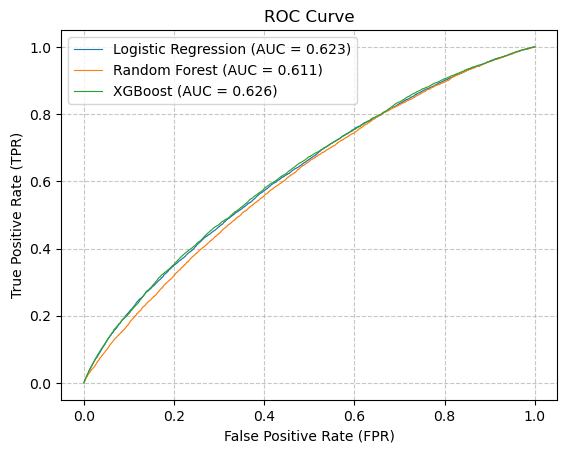

In [69]:
# probability predicted by logistic regression, random forest and XGBoost
test_label_pred_prob_lr = lr_model.predict_proba(test_features_processed)[:, 1]
test_label_pred_prob_rf = rf_model.predict_proba(test_features_processed)[:, 1]
test_label_pred_XGB = bst.predict(dtest)

# calculate FPR, TPR and threshold
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_label, test_label_pred_prob_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_label, test_label_pred_prob_rf)
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(test_label, test_label_pred_XGB)

# plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_score_lr:.3f})', linewidth=0.8)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.3f})', linewidth=0.8)
plt.plot(fpr_XGB, tpr_XGB, label=f'XGBoost (AUC = {auc_score_XGB:.3f})', linewidth=0.8)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()